# With Dec=5e-10, and others with Andrew's value, add a tanh on conductivity try to stop negative c(EC)

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp,tanh,sqrt;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import traceback
import imageio.v2 as imageio


In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
)

In [3]:
def electrolyte_conductivity_Nyman2008Exp_wEC(c_e,c_EC, T):
    x = c_EC / c_e
    coff = 1  
    ratio = ( coff/2 + coff/2 *  tanh((x-4.541*0.5)*1.5))
    sigma_e = (
        ratio * (
        0.1 * 0.06248 * (1+298.15-0.05559) * 
        (c_e/1e3) * (1 - 3.084 *sqrt(c_e/1e3) 
        + 1.33 *(1+ 0.03633 *(exp(1000/298.15))*c_e/1e3)   ) 
        / (1+(c_e/1e3)**4*( 0.00795 *exp(1000/298.15))) )
    )
    return sigma_e
def electrolyte_conductivity_Nyman2008Exp(c_e,c_EC, T):
    sigma_e = (
        (
        0.1 * 0.06248 * (1+298.15-0.05559) * 
        (c_e/1e3) * (1 - 3.084 *sqrt(c_e/1e3) 
        + 1.33 *(1+ 0.03633 *(exp(1000/298.15))*c_e/1e3)   ) 
        / (1+(c_e/1e3)**4*( 0.00795 *exp(1000/298.15))) )
    )
    return sigma_e

In [4]:
V_max = 4.2;        V_min = 2.5;
total_cycle = 500; save_at_cycles= 1
Experiment_short   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 1 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * 1 ) 
Experiment_s   = pybamm.Experiment( [ (
    f"Discharge at 1 C for 240 s", )    ] * 1 )   

In [5]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R7/'; 
Target  = 'a2_2_add_tanh_conduct_Dec=5e-10/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [6]:
De = 3e-10;Dec = 5e-10; Dcross  = 3e-11; Xi=-1.4; t_0plus=0.28

Para_0.search('mole')

In [7]:
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Nyman2008Exp";
Para = []
for i in range(0,2):
    Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
    Para_0['EC transference number'] =    Xi
    Para_0['Cation transference number'] =     t_0plus
    Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = Dcross
    Para_0['Typical EC Lithium ion cross diffusivity [m2.s-1]'] =  Dcross
    Para_0['Electrolyte diffusivity [m2.s-1]'] =  De
    Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  Dec
    Para_0['Ratio of lithium moles to SEI moles'] =  1
    Para.append(Para_0)
Para[0].update({
    'Electrolyte conductivity [S.m-1]':
    electrolyte_conductivity_Nyman2008Exp_wEC}, )
Para[1].update({
    'Electrolyte conductivity [S.m-1]':
    electrolyte_conductivity_Nyman2008Exp}, )

Xi =  list(np.linspace(-1.8, -1.0, 10))
print(type(Xi))

In [8]:
Sim = [];Sol=[]; 
for Para_i in Para: 
    model = pybamm.lithium_ion.DFN(     
        options={  
            "solvent diffusion": "EC wo refill"     } )
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    c_EC = model.variables["EC concentration [mol.m-3]"]
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["Electrolyte conductivity [S.m-1]"] =(
        Para_i['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
    sim = pybamm.Simulation(
        model, experiment = Experiment_short,
        parameter_values = Para_i,
        solver = pybamm.CasadiSolver(),)  
    try:
        sol = sim.solve(save_at_cycles=save_at_cycles,);
    except:
        print(
            'Fail for Electrolyte conductivity= ',
            Para_i['Electrolyte conductivity [S.m-1]'].__name__)
    else:
        Sol.append(sol)   
        print(
            'Succeed for Electrolyte conductivity= ',
            Para_i['Electrolyte conductivity [S.m-1]'].__name__)

using EC wo refill for Li+
Succeed for Electrolyte conductivity=  electrolyte_conductivity_Nyman2008Exp_wEC
using EC wo refill for Li+
Succeed for Electrolyte conductivity=  electrolyte_conductivity_Nyman2008Exp_wEC


print(Sol_ddiff["Electrolyte conductivity [S.m-1]"].entries[:,51] )
print(Sol_ddiff["Electrolyte diffusivity [m2.s-1]"].entries[:,-1])

In [9]:
fs = 17
font = {'family' : 'DejaVu Sans','size': fs}
mpl.rc('font', **font)

In [14]:
Sigma_e = ["Exp with EC tanh","Exp without EC tanh",]
str = "Electrolyte conductivity"

In [19]:
label = [str+"="+Sigma for Sigma in Sigma_e]
output_variables3 = [
    "Terminal voltage [V]",
    #"Negative electrode potential [V]",
    "Negative electrode current density",
    "Electrolyte potential [V]",
    "Electrolyte current density [A.m-2]",
    'Electrolyte conductivity [S.m-1]',
    #"Sum of positive electrode interfacial current densities",

    #"Li+ source term refill",
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='tight',time_unit='hours',n_rows=2,
    figsize = (12,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=2.1868155109890037, step=0.02186815510989004…

In [16]:
# post-processing with function - dynamic plots
Sigma_e = ["Exp With EC tanh", "Exp Without EC tanh"];
str = "Electrolyte conductivity";
PlotDynamics(Sol,str,Sigma_e,BasicPath , Target,"Tru",17)

interactive(children=(FloatSlider(value=0.0, description='t', max=2.1868155109890037, step=0.02186815510989004…

interactive(children=(FloatSlider(value=0.0, description='t', max=2.1868155109890037, step=0.02186815510989004…

interactive(children=(FloatSlider(value=0.0, description='t', max=2.1868155109890037, step=0.02186815510989004…

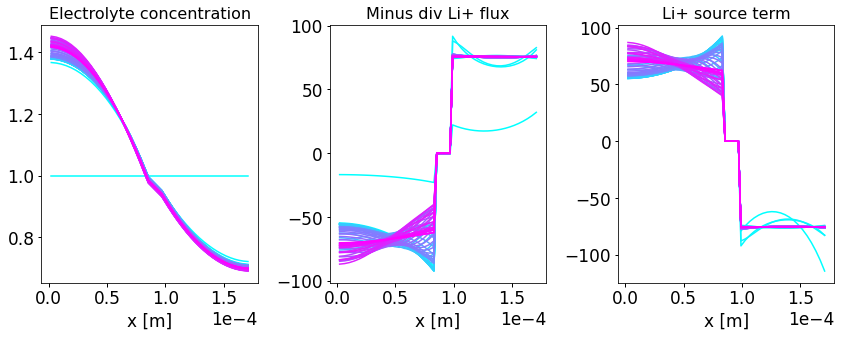

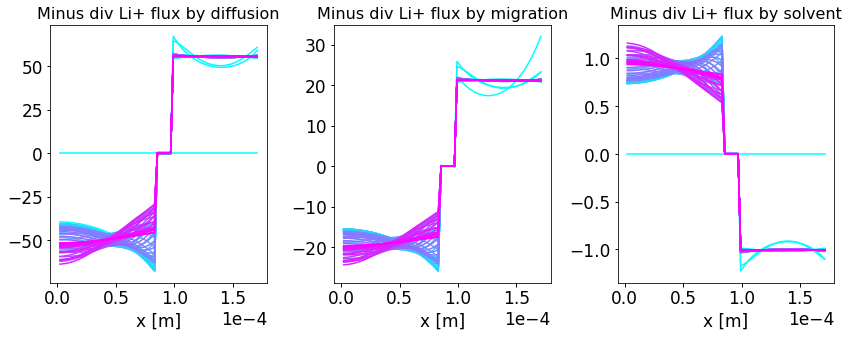

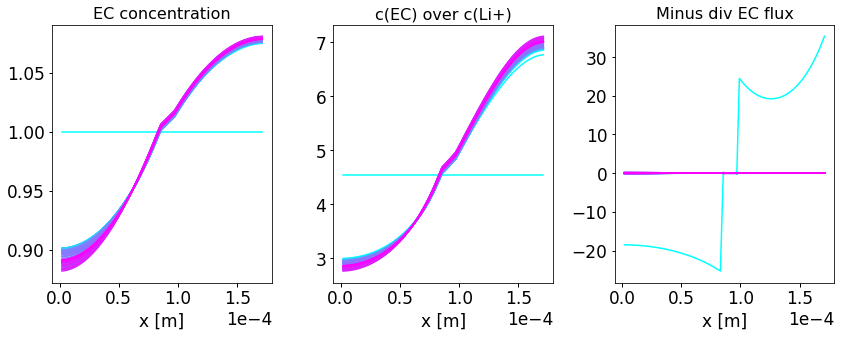

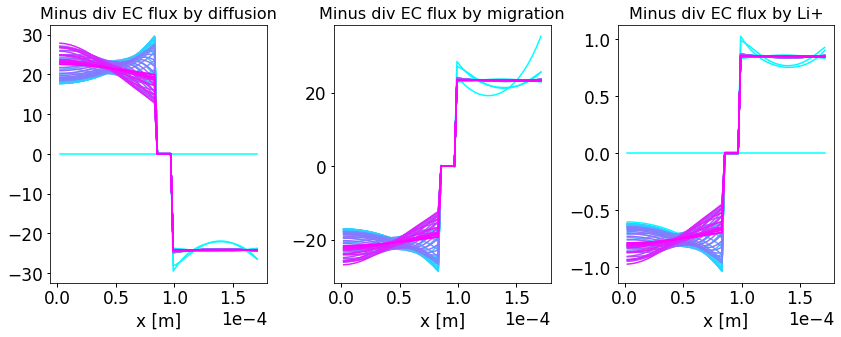

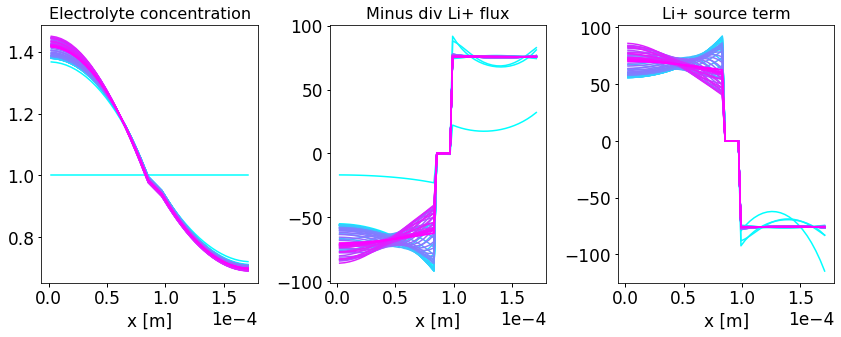

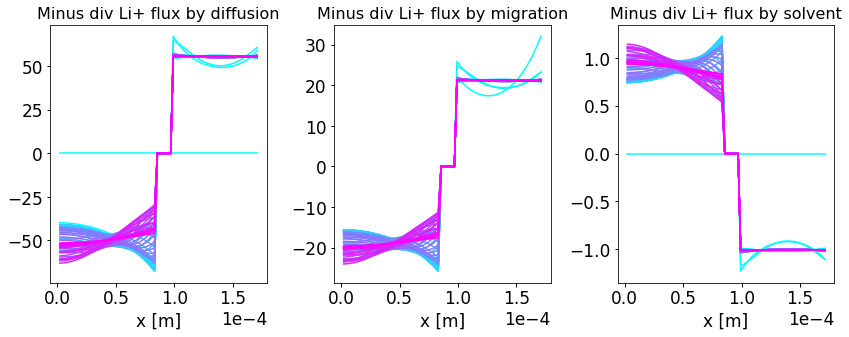

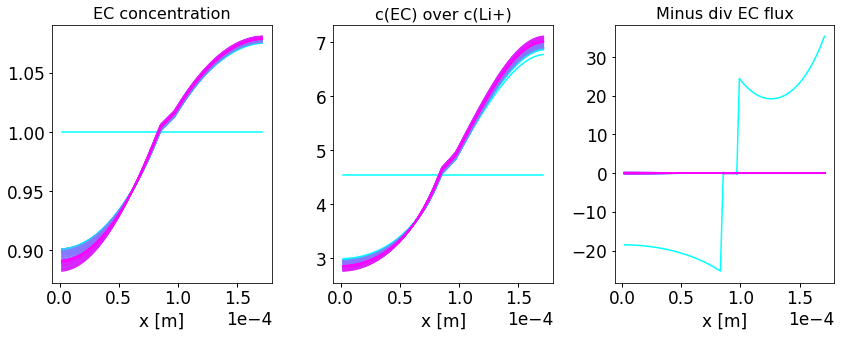

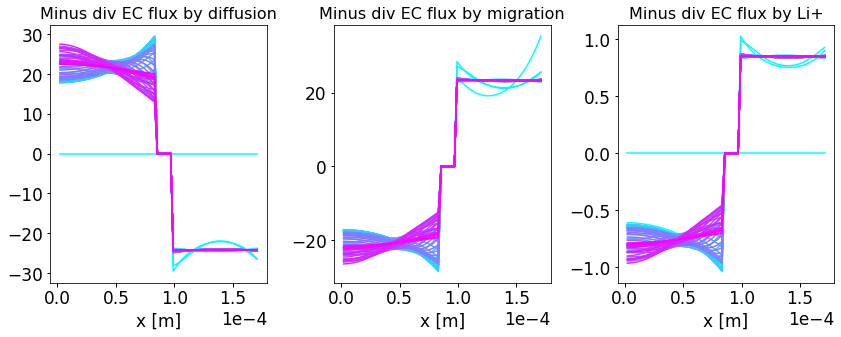

In [17]:
# static plot: loop all single case
cycle = 0; step_CD = 0;   step_CC = 1; step_CV = 2; 
Plot_Single_Static(
    Sol,str,cycle, step_CD, 
    Sigma_e,BasicPath , 
    Target,"Tru",'cool',17,200)
